In [1]:
import copy
import os
import sys
import time

import jax
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from helper import df_to_latex, fig_path, set_figsize, tab_path

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# Import code from src
sys.path.insert(0, '../src/')
import vmc  # noqa

# Set plot and dataframe style
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})

fontsize = "large"
params = {"font.family": "serif",
          "font.sans-serif": ["Computer Modern"],
          "axes.labelsize": fontsize,
          "legend.fontsize": fontsize,
          "xtick.labelsize": fontsize,
          "ytick.labelsize": fontsize,
          "legend.handlelength": 2
          }

plt.rcParams.update(params)
plt.rc('text', usetex=True)

pd.set_option('display.max_columns', 50)

jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'cpu')

In [2]:
df_rwm = pd.read_csv("../data/sample_ashonib_rwm.csv")
df_rwm['Algorithm'] = 'RWM'
df_rwm

,chain_id,nparticles,dim,scale,eta,alpha,energy,std_error,variance,scaled_energy,scaled_std_error,scaled_variance,accept_rate,nsamples,total_cycles,tuning_cycles,optimize_cycles,warmup_cycles,Algorithm
0,1,100,3,0.106733,0.01,0.502922,149.939392,0.029787,0.015962,1.499394,0.029787,0.015962,0.196777,4096,64096,10000,50000,0,RWM
1,2,100,3,0.088209,0.01,0.499697,149.982134,0.002176,0.000162,1.499821,0.002176,0.000162,0.318115,4096,64096,10000,50000,0,RWM
2,3,100,3,0.043227,0.01,0.500032,150.000358,0.001138,0.000023,1.500004,0.001138,0.000023,0.657471,4096,64096,10000,50000,0,RWM
3,4,100,3,0.095099,0.01,0.498989,150.020524,0.022193,0.008453,1.500205,0.022193,0.008453,0.238281,4096,64096,10000,50000,0,RWM
4,5,100,3,0.095099,0.01,0.501767,149.951915,0.017444,0.005453,1.499519,0.017444,0.005453,0.252197,4096,64096,10000,50000,0,RWM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,12,100,3,0.104609,0.01,0.499963,149.999798,0.000157,0.000005,1.499998,0.000157,0.000005,0.211647,131072,191072,10000,50000,0,RWM
92,13,100,3,0.070027,0.01,0.499385,149.998776,0.004766,0.004984,1.499988,0.004766,0.004984,0.425751,131072,191072,10000,50000,0,RWM
93,14,100,3,0.088209,0.01,0.499579,149.995875,0.002409,0.000900,1.499959,0.002409,0.000900,0.319244,131072,191072,10000,50000,0,RWM
94,15,100,3,0.088209,0.01,0.500065,150.001190,0.000306,0.000021,1.500012,0.000306,0.000021,0.314598,131072,191072,10000,50000,0,RWM


In [3]:
df_lmh = pd.read_csv("../data/sample_ashonib_lmh.csv")
df_lmh['Algorithm'] = 'LMH'
df_lmh

,chain_id,nparticles,dim,dt,eta,alpha,energy,std_error,variance,scaled_energy,scaled_std_error,scaled_variance,accept_rate,nsamples,total_cycles,tuning_cycles,optimize_cycles,warmup_cycles,Algorithm
0,1,100,3,0.492487,0.01,0.498687,150.078883,0.006064,1.565008e-03,1.500789,0.006064,1.565008e-03,0.331787,4096,64096,10000,50000,0,LMH
1,2,100,3,0.407014,0.01,0.499483,150.022756,0.003475,4.752206e-04,1.500228,0.003475,4.752206e-04,0.477051,4096,64096,10000,50000,0,LMH
2,3,100,3,0.366312,0.01,0.500289,149.997420,0.003496,2.464598e-04,1.499974,0.003496,2.464598e-04,0.410400,4096,64096,10000,50000,0,LMH
3,4,100,3,0.407014,0.01,0.500120,149.995966,0.000611,1.676327e-05,1.499960,0.000611,1.676327e-05,0.368408,4096,64096,10000,50000,0,LMH
4,5,100,3,0.407014,0.01,0.498831,150.043620,0.007815,2.405571e-03,1.500436,0.007815,2.405571e-03,0.477295,4096,64096,10000,50000,0,LMH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,12,100,3,0.366312,0.01,0.500226,149.990585,0.000372,8.374906e-05,1.499906,0.000372,8.374906e-05,0.530212,131072,191072,10000,50000,0,LMH
92,13,100,3,0.443238,0.01,0.500003,149.999860,0.000005,1.433364e-08,1.499999,0.000005,1.433364e-08,0.370567,131072,191072,10000,50000,0,LMH
93,14,100,3,0.336375,0.01,0.499196,150.030922,0.001325,1.133516e-03,1.500309,0.001325,1.133516e-03,0.597107,131072,191072,10000,50000,0,LMH
94,15,100,3,0.492487,0.01,0.499664,150.015752,0.000848,1.774969e-04,1.500158,0.000848,1.774969e-04,0.259415,131072,191072,10000,50000,0,LMH


In [4]:
df = pd.concat([df_rwm, df_lmh], ignore_index=True)
df

,chain_id,nparticles,dim,scale,eta,alpha,energy,std_error,variance,scaled_energy,scaled_std_error,scaled_variance,accept_rate,nsamples,total_cycles,tuning_cycles,optimize_cycles,warmup_cycles,Algorithm,dt
0,1,100,3,0.106733,0.01,0.502922,149.939392,0.029787,1.596153e-02,1.499394,0.029787,1.596153e-02,0.196777,4096,64096,10000,50000,0,RWM,NaN
1,2,100,3,0.088209,0.01,0.499697,149.982134,0.002176,1.623072e-04,1.499821,0.002176,1.623072e-04,0.318115,4096,64096,10000,50000,0,RWM,NaN
2,3,100,3,0.043227,0.01,0.500032,150.000358,0.001138,2.260465e-05,1.500004,0.001138,2.260465e-05,0.657471,4096,64096,10000,50000,0,RWM,NaN
3,4,100,3,0.095099,0.01,0.498989,150.020524,0.022193,8.453272e-03,1.500205,0.022193,8.453272e-03,0.238281,4096,64096,10000,50000,0,RWM,NaN
4,5,100,3,0.095099,0.01,0.501767,149.951915,0.017444,5.452705e-03,1.499519,0.017444,5.452705e-03,0.252197,4096,64096,10000,50000,0,RWM,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,12,100,3,NaN,0.01,0.500226,149.990585,0.000372,8.374906e-05,1.499906,0.000372,8.374906e-05,0.530212,131072,191072,10000,50000,0,LMH,0.366312
188,13,100,3,NaN,0.01,0.500003,149.999860,0.000005,1.433364e-08,1.499999,0.000005,1.433364e-08,0.370567,131072,191072,10000,50000,0,LMH,0.443238
189,14,100,3,NaN,0.01,0.499196,150.030922,0.001325,1.133516e-03,1.500309,0.001325,1.133516e-03,0.597107,131072,191072,10000,50000,0,LMH,0.336375
190,15,100,3,NaN,0.01,0.499664,150.015752,0.000848,1.774969e-04,1.500158,0.000848,1.774969e-04,0.259415,131072,191072,10000,50000,0,LMH,0.492487


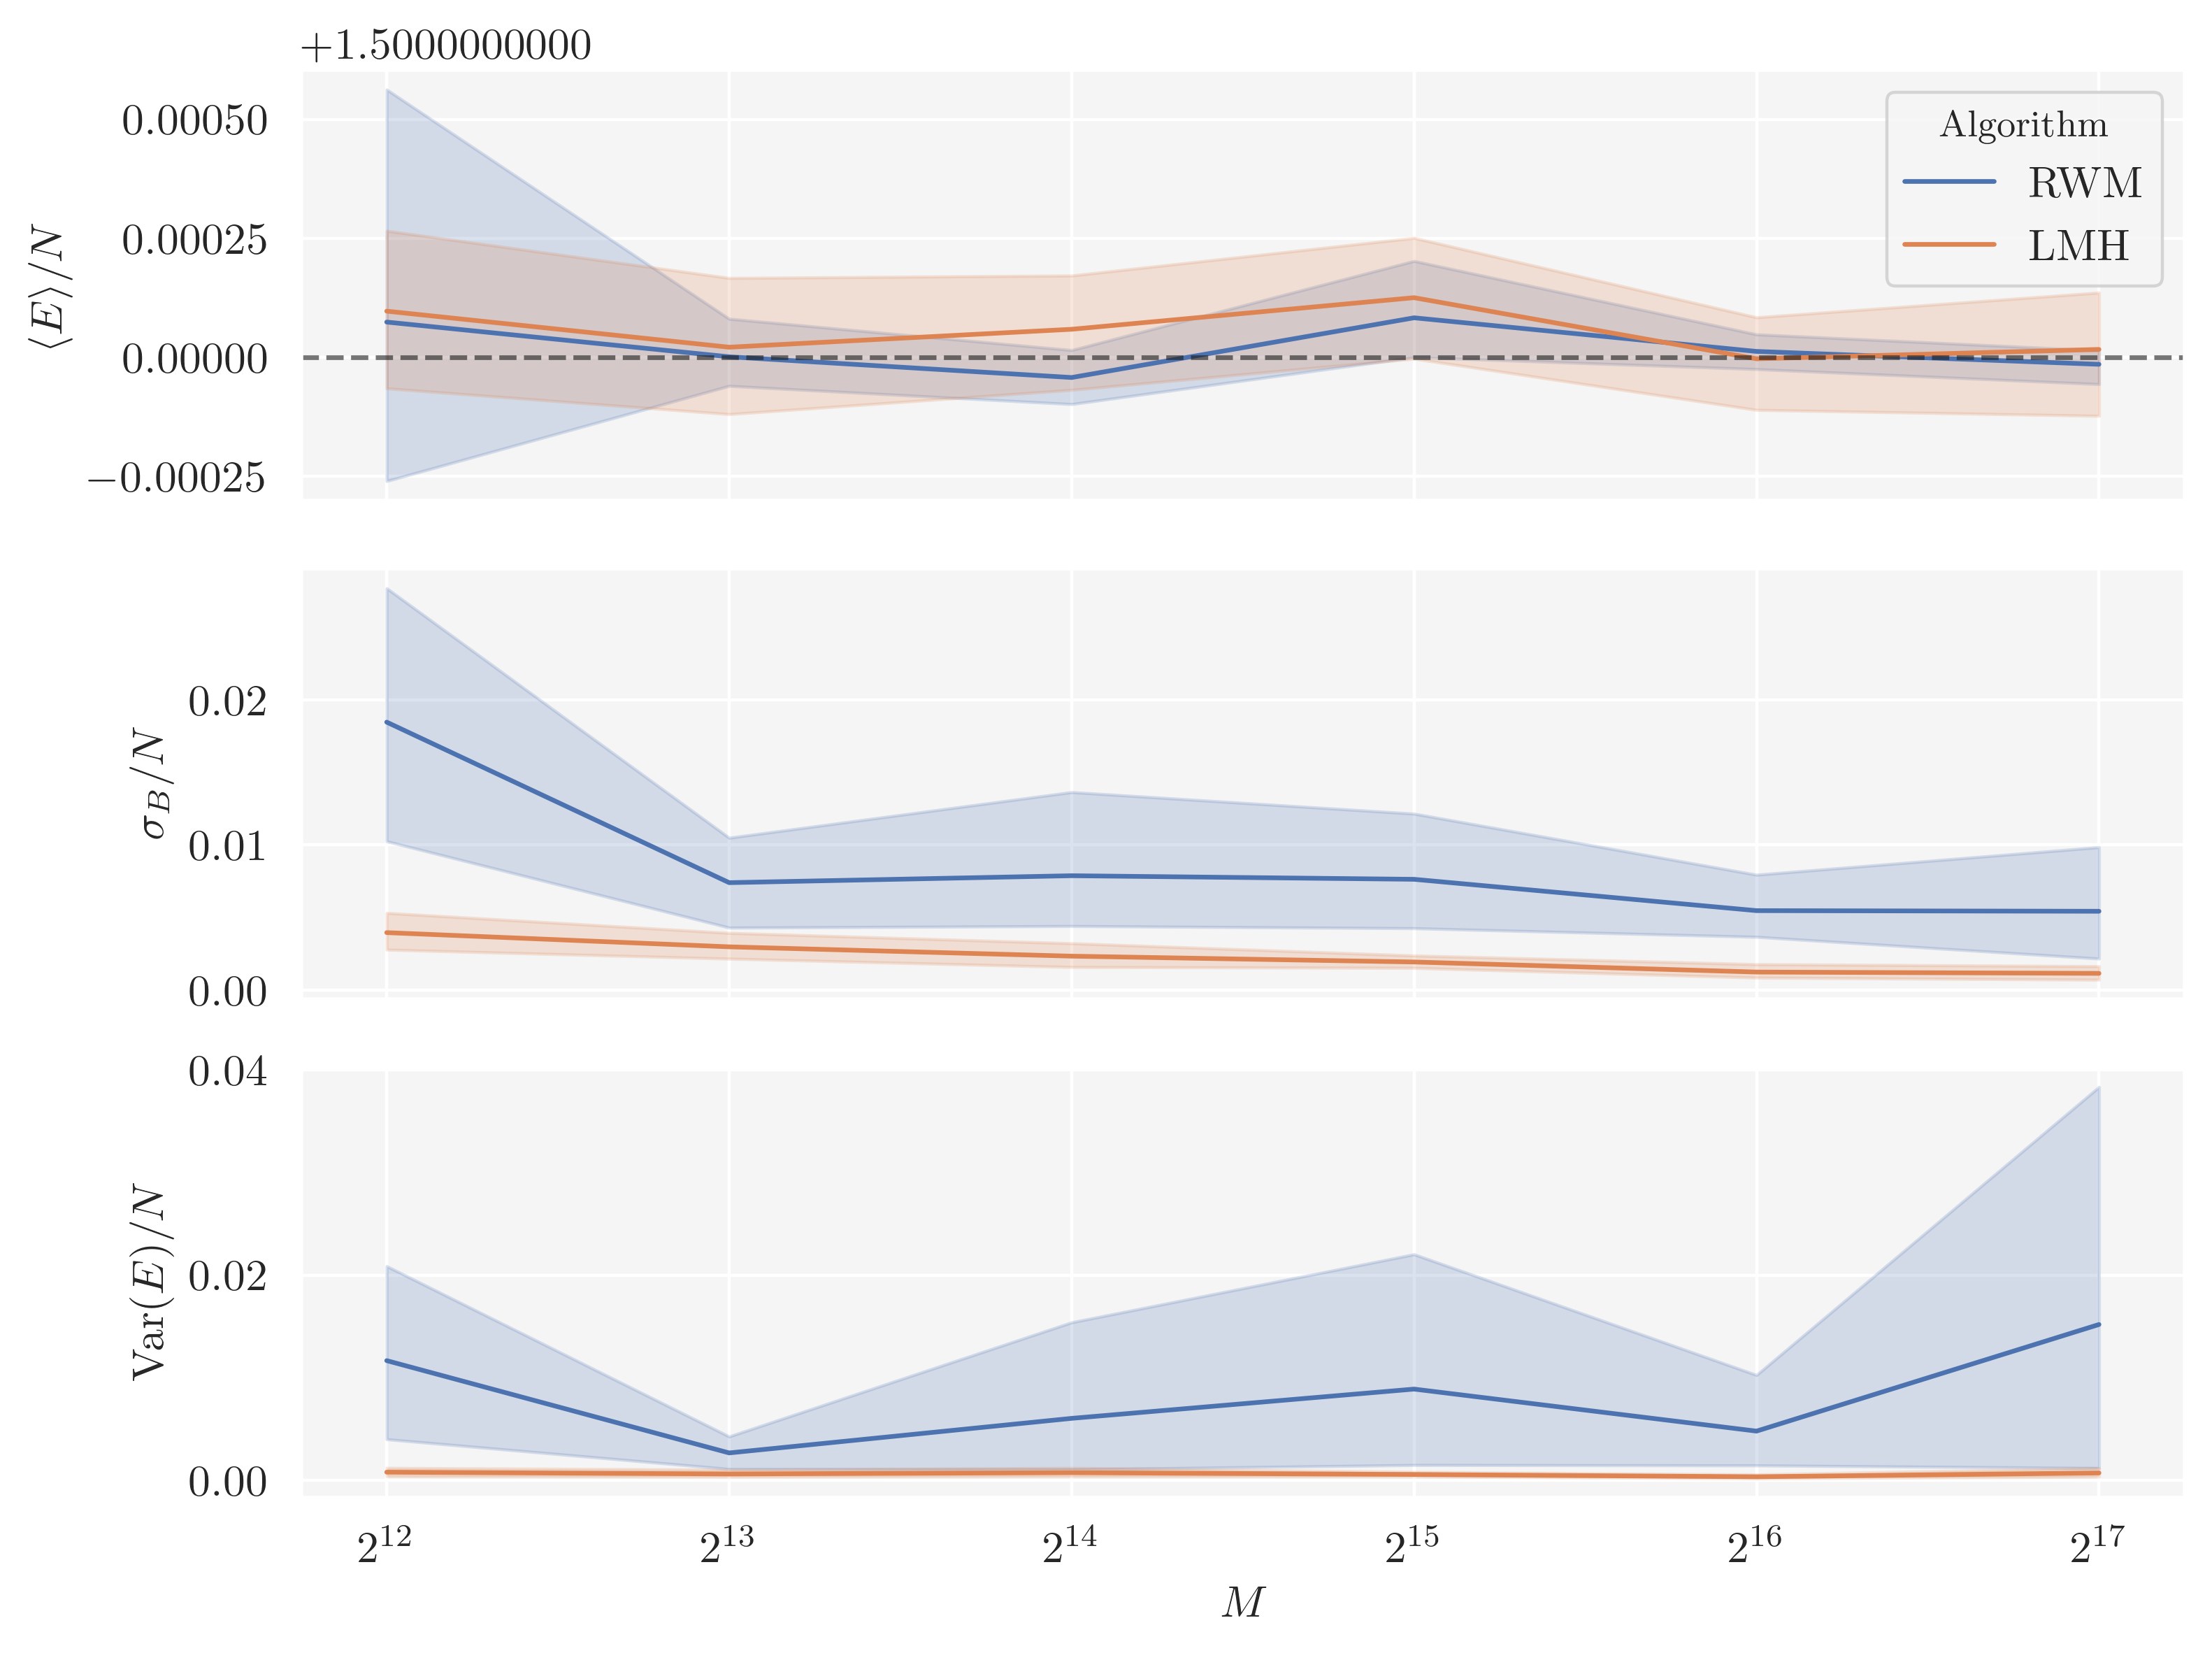

In [9]:
fig, axes = plt.subplots(nrows=3, 
                         ncols=1, 
                         figsize=(8, 6), 
                         tight_layout=True, 
                         sharex=True,
                         dpi=200
                        )

sns.lineplot(data=df, x="nsamples", y="scaled_energy", hue="Algorithm", ax=axes[0])
axes[0].axhline(1.5, ls="--", color="k", alpha=0.6)
#axes[0].set_xscale('log', base=2)
axes[0].set(ylabel=r'$\langle E \rangle / N$')

sns.lineplot(data=df, x="nsamples", y="scaled_std_error", hue="Algorithm", ax=axes[1])
#axes[1].set_xscale('log', base=2)
axes[1].set(ylabel=r'$\sigma_B / N$')
axes[1].legend().set_visible(False)

sns.lineplot(data=df, x="nsamples", y="scaled_variance", hue="Algorithm", ax=axes[2])
axes[2].set_xscale('log', base=2)
axes[2].set(xlabel=r'$M$', ylabel=r'$\mathrm{Var}(E)/N$')
axes[2].legend().set_visible(False)

fig.savefig(fig_path("ashonib_N100_rwm_vs_lmh.pdf"), bbox_inches='tight')